In [2]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
# torch.nn is the main package to build the neural networks
from torch import nn
import time
# Visulaization
import matplotlib.pyplot as plt

/Users/mariiaeremina/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/mariiaeremina/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <CC4BC91F-8B6A-3F9A-B9EB-A2B9D578E202> /Users/mariiaeremina/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <408F81C0-C6C8-33EF-B02E-B683F7178A71> /Users/mariiaeremina/opt/anaconda3/lib/python3.9/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# we try on FashionMNIST, a image dataset predefined in Pytorch

training_data = datasets.FashionMNIST(
    root="data", # the path which you download the data into.
    train=True, # it has a predefined data split. Set train=True to get the trainning data and train=False for the testing data.
    download=True, # you need to download the dataset in the first time you use it.
    transform=ToTensor() # apply transform to the images. Here we convert the images into tensors.
)

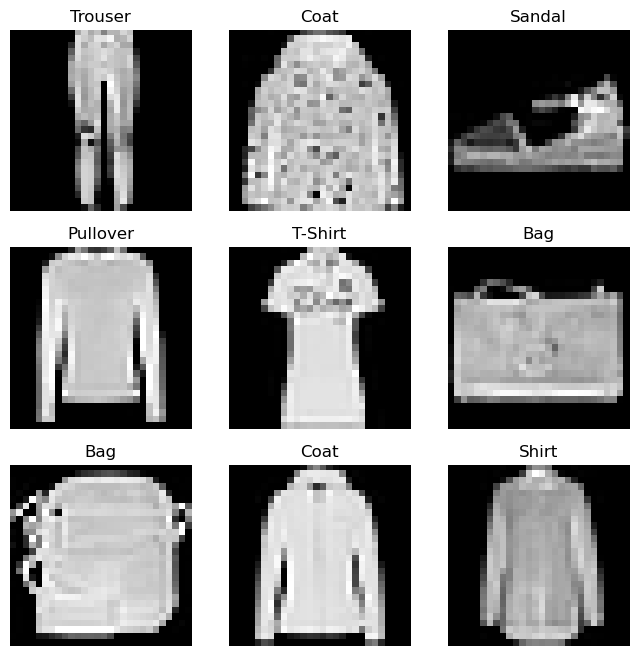

In [4]:
# For a better visualization, we map labels from integer to string.
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()

    # Get image and the corresponding label from the dataset
    img, label = training_data[sample_idx]

    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
# GPUs are prefered to train the models. So we need to first set the device.
# Note that we do not have to use GPUs for this exercise.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


https://www.ruder.io/optimizing-gradient-descent/ Optimization

In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# Hyper-parameters
learning_rate = 1e-3
batch_size = 64
epochs = 10

# Build training and test dataset on FashionMNIST
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# Setup the Dataloader for training
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

# Create an MLP with 3 hidden layers
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


# Initialize the loss function with the cross-entropy loss
loss_fn = nn.CrossEntropyLoss()

In [7]:
from torchsummary import summary
model = NeuralNetwork()
summary(model)

Layer (type:depth-idx)                   Param #
├─Flatten: 1-1                           --
├─Sequential: 1-2                        --
|    └─Linear: 2-1                       401,920
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       262,656
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Flatten: 1-1                           --
├─Sequential: 1-2                        --
|    └─Linear: 2-1                       401,920
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       262,656
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0

In [8]:
# Define a function of training loop
def train_loop(dataloader, model, loss_fn, optimizer):

    size = len(dataloader.dataset)

    # Set the model to train state
    model.train()
    
    # Load samples from the dataloader
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # There are three basic steps for backpropagation:
        # 1. Set the gradient of trainable parameters to 0.
        optimizer.zero_grad()
        # 2. Automatically calculate the gradient of trainable parameters.
        loss.backward()
        # 3. Automatically update the trainable parameters using the gradient.
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Define a function of test loop
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100*correct, test_loss

In [13]:
optimizers = [
             torch.optim.SGD(model.parameters(), lr=learning_rate),
             torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.1), 
             torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9),
             torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9,nesterov=True),
             torch.optim.ASGD(model.parameters(), lr=learning_rate),
             torch.optim.Adagrad(model.parameters(),lr=learning_rate),
             torch.optim.Rprop(model.parameters(),lr=learning_rate),
             torch.optim.RAdam(model.parameters(),lr=learning_rate),
             torch.optim.Adadelta(model.parameters(),lr=learning_rate),
             torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.9),
             torch.optim.RMSprop(model.parameters(), lr=learning_rate),
             torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999)),
             torch.optim.Adam(model.parameters(), amsgrad=True),
             torch.optim.AdamW(model.parameters(),lr=learning_rate),
             torch.optim.Adamax(model.parameters(),lr=learning_rate),
             torch.optim.NAdam(model.parameters(),lr=learning_rate),
             ]

In [ ]:
import time
import torch
import torch.optim as optim

# Define your neural network class (assuming you have it defined as NeuralNetwork)

# Define your data loaders (train_dataloader and test_dataloader)
# Define your loss function (loss_fn)

learning_rates = [0.01, 0.001]
epochs = 10

DiffGrad= {}

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    
    model = NeuralNetwork()  # Create a new model for each learning rate
    optimizer =  optim.DiffGrad(model.parameters(), lr=learning_rate)
    
    res_lr = {}
    
    start_time = time.time()
    
    for t in range(epochs):
        print(f"Epoch {t + 1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer)
        acc, loss = test_loop(test_dataloader, model, loss_fn)
        res_lr[t] = (acc, loss)
    
    end_time = time.time()
    time_elapsed = end_time - start_time
    
    DiffGrad[lr] = {
        'results': res_lr,
        'time_elapsed': time_elapsed
    }

In [121]:
# name with 0 means learnign rate 0.001
results = [


"results_SGD", "results_SGD0",
"results_SGD_weight_decay", "results_SGD_weight_decay0",
"results_SGD_momentum", "results_SGD_momentum0",
"results_SGD_momentum_nesterov", "results_SGD_momentum_nesterov0",
"ASGD", "ASGD0",
"Adagrad", "Adagrad0",
"Rprop", "Rprop0",
"RAdam", "RAdam0",
"Adadelta", "Adadelta0",
"RMSprop_alpha09", "RMSprop_alpha090",
"RMSprop", "RMSprop0",
"Adam", "Adam0",
"Adam_amsgrad", "Adam_amsgrad0",
"AdamW", "AdamW0",
"Adamax", "Adamax0",
"NAdam", "NAdam0"
      

]

In [16]:
len(optimizers)

16

In [11]:
import json
with open("results_optim.json", "r") as json_file:
    loaded_data = json.load(json_file)


In [192]:

time_optim = []
for i in range(16):
    for z in ['0.01','0.001']:
        data = loaded_data[i][z]['time_elapsed']
        time_optim.append(data)

In [207]:
time_optim_17_optim = []

for i,z in enumerate(time_optim):
    if i in indx:
        time_optim_17_optim .append(z)


In [32]:
accuracy_optim = []
for i in range(16):
    for z in ['0.01','0.001']:
        data = [lst[0] for lst in loaded_data[i][z]['results'].values()]
        accuracy_optim.append(data)

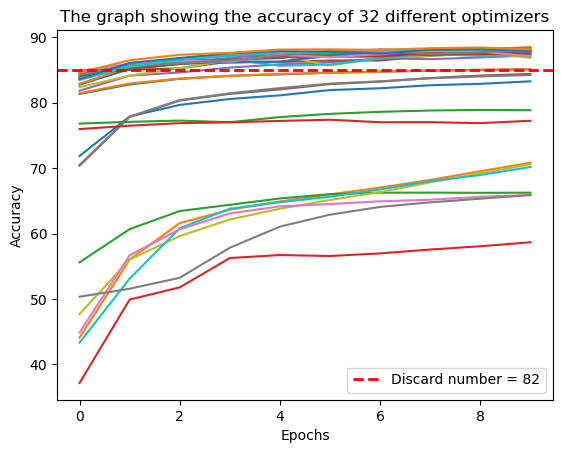

In [183]:


# Create a figure and axes
fig, ax = plt.subplots()

# Create a line plot for each sublist in the data
for sublist in accuracy_optim:
    ax.plot(sublist)

# Add a bold red horizontal line at y = 85
ax.axhline(y=85, color='red', linewidth=2, linestyle='--', label='Discard number = 82')

# Set labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('The graph showing the accuracy of 32 different optimizers')

# Show the legend
ax.legend()

# Show the plot
plt.show()


In [268]:
max_more_82 = []
indx = []
for i in range(32):
    
    if min(accuracy_optim[i]) > 82:


        max_more_82.append(accuracy_optim[i])
        indx.append(i)
        

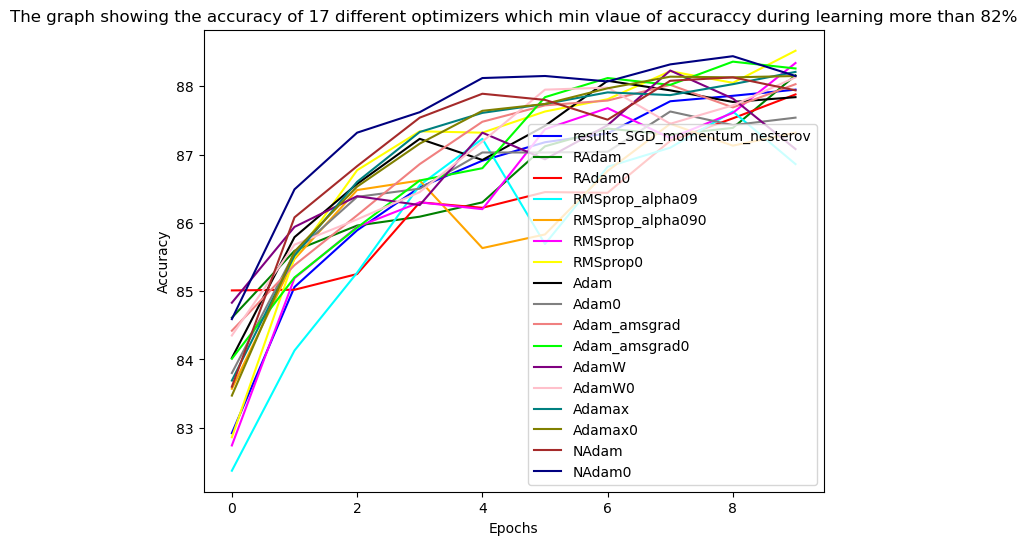

In [189]:

# Your list of lists
data = max_more_82
ind = indx


# Define a list of 17 distinct colors
normal_colors = [
    'blue', 'green', 'red', 'cyan', 'orange',
    'magenta', 'yellow', 'black', 'gray',
    'lightcoral', 'lime', 'purple', 'pink', 'teal',
    'olive', 'brown', 'navy'
]


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the data with normal colors
for i, sublist in enumerate(data):
    ax.plot(sublist, label=results[ind[i]], color=normal_colors[i % len(normal_colors)])

# Set labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('The graph showing the accuracy of 17 different optimizers which min vlaue of accuraccy during learning more than 82%')

# Add a legend to differentiate the lines
ax.legend()

# Show the plot
plt.show()


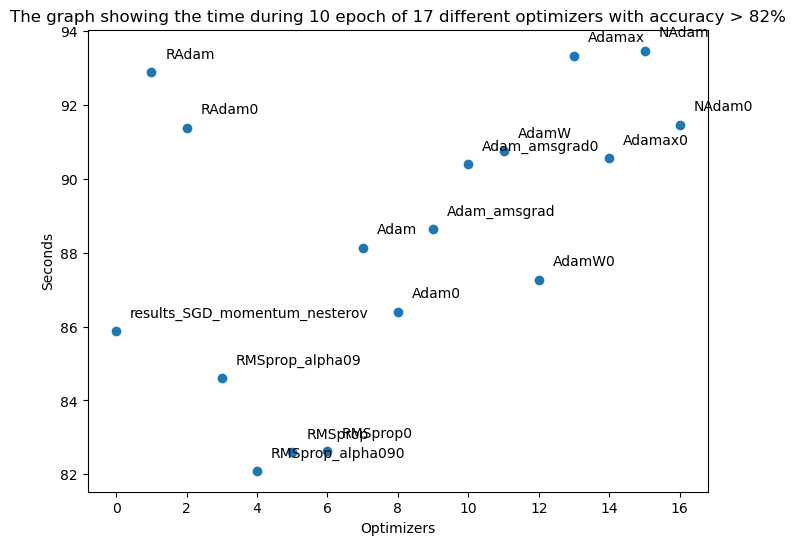

In [227]:

# Assuming you have data and ind defined as lists of single numbers
data = time_optim_17_optim
ind = indx

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Select specific labels from the results list
selected_labels = [results[i] for i in ind]
# Plot the data as scatter points
scatter = ax.scatter(range(len(data)), data)

# Set labels and title
ax.set_xlabel('Optimizers')
ax.set_ylabel('Seconds')
ax.set_title('The graph showing the time during 10 epoch of 17 different optimizers with accuracy > 82%')

# Add labels near the points
for i, txt in enumerate(selected_labels):
    ax.annotate(txt, (i, data[i]), xytext=(10,10), textcoords='offset points')

# Show the plot
plt.show()
# Show the plot
plt.show()



In [269]:
mean_optim = []
for i in max_more_82:
   mean_optim.append(np.mean(i))



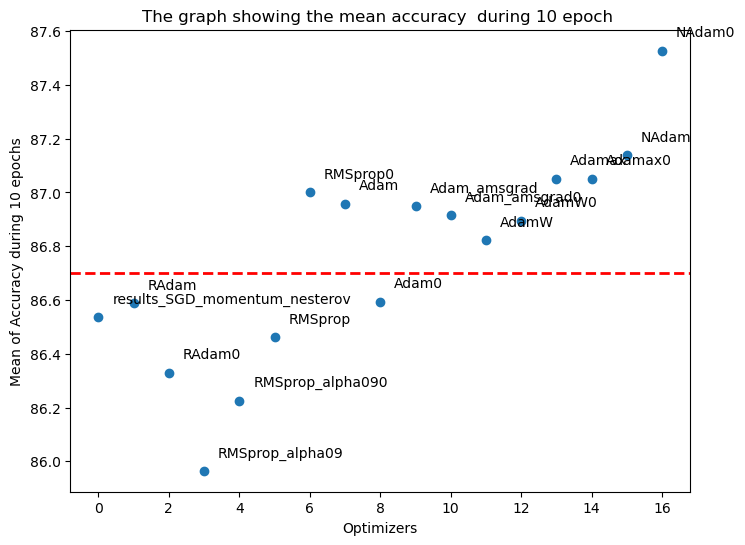

In [271]:

# Assuming you have data and ind defined as lists of single numbers
data = mean_optim
ind = indx

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Select specific labels from the results list
selected_labels = [results[i] for i in ind]
# Plot the data as scatter points
scatter = ax.scatter(range(len(data)), data)

# Set labels and title
ax.set_xlabel('Optimizers')
ax.set_ylabel('Mean of Accuracy during 10 epochs')
ax.set_title('The graph showing the mean accuracy  during 10 epoch ')

# Add labels near the points
for i, txt in enumerate(selected_labels):
    ax.annotate(txt, (i, data[i]), xytext=(10,10), textcoords='offset points')

# Add a bold red horizontal line at y = 85
ax.axhline(y=86.7, color='red', linewidth=2, linestyle='--', label='Discard number below= 86.7')

# Show the plot
plt.show()
# Show the plot
plt.show()

In [252]:
mean_optim_86_7 = []
indx_86_7 = []
for z,i in enumerate(max_more_82):
   print(np.mean(i))
   if (np.mean(i) > 86.7):
       mean_optim_86_7.append(i)
       indx_86_7.append(indx[z])

86.53799999999998
86.589
86.33
85.965
86.226
86.46100000000001
87.001
86.958
86.594
86.95
86.916
86.82300000000001
86.89500000000001
87.051
87.051
87.13999999999999
87.52699999999999


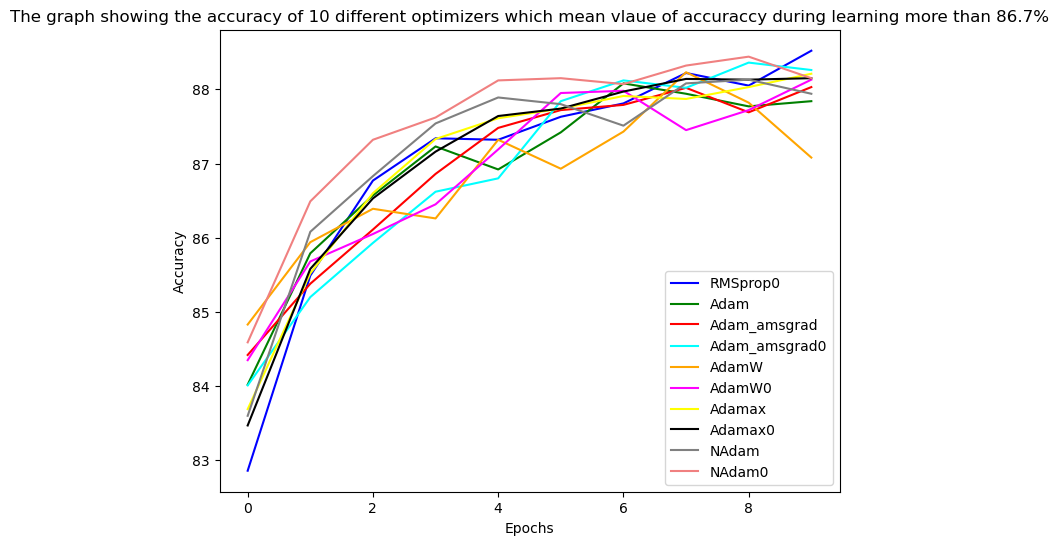

In [313]:
# Your list of lists
data = mean_optim_86_7
ind = indx_86_7


# Define a list of 10 distinct colors
normal_colors = [
    'blue', 'green', 'red', 'cyan', 'orange',
    'magenta', 'yellow', 'black', 'gray',
    'lightcoral', 'lime', 'purple', 'pink', 'teal',
    'olive', 'brown', 'navy'
]


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the data with normal colors
for i, sublist in enumerate(data):
    ax.plot(sublist, label=results[ind[i]], color=normal_colors[i % len(normal_colors)])

# Set labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('The graph showing the accuracy of 10 different optimizers which mean vlaue of accuraccy during learning more than 86.7%')

# Add a legend to differentiate the lines
ax.legend()

# Show the plot
plt.show()

In [300]:
vis_best = []

for i in range(32):
    

    if i in [21,28,29,30,31]:

        vis_best.append(accuracy_optim[i])
        indx.append(i)

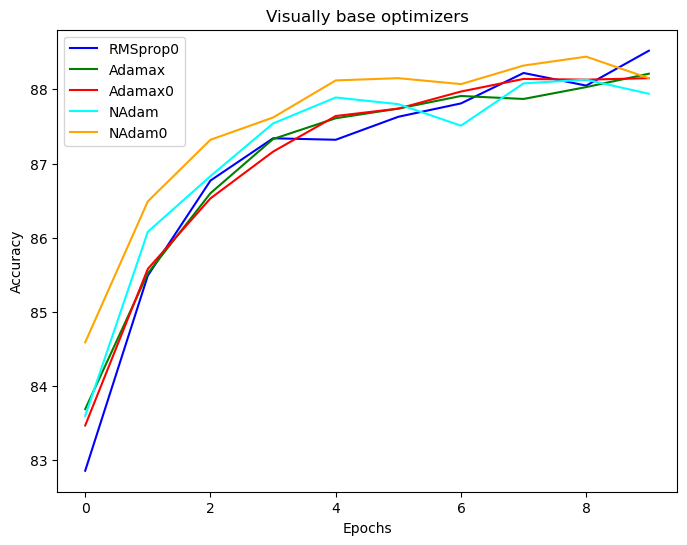

In [301]:
# Your list of lists
data = vis_best
ind = [21,28,29,30,31]


# Define a list of 10 distinct colors
normal_colors = [
    'blue', 'green', 'red', 'cyan', 'orange',
    'magenta', 'yellow', 'black', 'gray',
    'lightcoral', 'lime', 'purple', 'pink', 'teal',
    'olive', 'brown', 'navy'
]


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the data with normal colors
for i, sublist in enumerate(data):
    ax.plot(sublist, label=results[ind[i]], color=normal_colors[i % len(normal_colors)])

# Set labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Visually base optimizers')

# Add a legend to differentiate the lines
ax.legend()

# Show the plot
plt.show()

In [415]:
viss = ['NAdam0','Adamax0','Adamax','RMSprop0','NAdam']

In [ ]:
# df ,left index of top 5, column : min value, mean value, max value ,time, visually

In [396]:
mean_df = sorted(zip(mean_optim,[results[i] for i in indx]))[-10::]

In [295]:

time_df = sorted(zip(time_optim_17_optim,[results[i] for i in indx]))

In [ ]:
mean_optim_86_7 = []
indx_86_7 = []
for z,i in enumerate(max_more_82):
   print(np.mean(i))
   if (np.mean(i) > 86.7):
       mean_optim_86_7.append(i)
       indx_86_7.append(indx[z])

In [316]:
ma_df = []
for i in mean_optim_86_7:
    ma_df.append(max(i))



In [314]:
min_df = sorted(zip(m_df,[results[i] for i in indx_86_7]))

In [340]:
max_df = sorted(zip(ma_df,[results[i] for i in indx_86_7]))

In [420]:
pd.DataFrame(viss)

,0
0,NAdam0
1,Adamax0
2,Adamax
3,RMSprop0
4,NAdam


In [442]:
import pandas as pd

# Assuming you have a DataFrame max_df[::-1]
# Here, we'll create a sample DataFrame for demonstration
df = pd.DataFrame(viss)
df = df.rename(columns={0: 'Visual Top'})

# Define a function to apply yellow background to specific columns
def color_columns_green(series):

    return ['background-color: lightgreen'] * len(series)


# Apply the styling function to the DataFrame
styled_df_vis = df.style.apply(color_columns_green, axis=0)

# Display the styled DataFrame
styled_df_vis

,Visual Top
0,NAdam0
1,Adamax0
2,Adamax
3,RMSprop0
4,NAdam


In [452]:
import pandas as pd
from pandas.io.formats.style import Styler
# Assuming that these are your Styler objects: styled_df_vis, styled_df_min, styled_df_max, styled_df_mean, styled_df_time

# Extract the data and Styler objects from each Styler
styler_list = [styled_df_vis, styled_df_min, styled_df_max, styled_df_mean, styled_df_time]
dataframes = [styler.data for styler in styler_list]

# Concatenate the DataFrames along columns (axis=1)
concatenated_data = pd.concat(dataframes, axis=1)



In [457]:

# Replace NaN with a hyphen ("-")
concatenated_data = concatenated_data.fillna('-')


In [475]:
import pandas as pd
from IPython.display import display

# Print DataFrames horizontally using the display function
display(styled_df_vis, styled_df_min, styled_df_max, styled_df_mean, styled_df_time)




,Visual Top
0,NAdam0
1,Adamax0
2,Adamax
3,RMSprop0
4,NAdam


,Min_Accuracy,Optimizer
0,84.830000,AdamW
1,84.590000,NAdam0
2,84.420000,Adam_amsgrad
3,84.350000,AdamW0
4,84.020000,Adam
5,84.010000,Adam_amsgrad0
6,83.690000,Adamax
7,83.600000,NAdam
8,83.470000,Adamax0
9,82.860000,RMSprop0


,Max_Accuracy,Optimizer
0,88.520000,RMSprop0
1,88.440000,NAdam0
2,88.360000,Adam_amsgrad0
3,88.230000,AdamW
4,88.210000,Adamax
5,88.150000,Adamax0
6,88.130000,NAdam
7,88.130000,AdamW0
8,88.080000,Adam
9,88.030000,Adam_amsgrad


,Mean_Accuracy,Optimizer
0,87.527000,NAdam0
1,87.140000,NAdam
2,87.051000,Adamax0
3,87.051000,Adamax
4,87.001000,RMSprop0
5,86.958000,Adam
6,86.950000,Adam_amsgrad
7,86.916000,Adam_amsgrad0
8,86.895000,AdamW0
9,86.823000,AdamW


,Mean_Accuracy,Optimizer
0,82.097050,RMSprop_alpha090
1,82.602763,RMSprop
2,82.620995,RMSprop0
3,84.607772,RMSprop_alpha09
4,85.884245,results_SGD_momentum_nesterov
5,86.400450,Adam0
6,87.270641,AdamW0
7,88.133827,Adam
8,88.647249,Adam_amsgrad
9,90.391927,Adam_amsgrad0


In [479]:
import pandas as pd
from IPython.display import display, HTML

# Create some example DataFrames
styled_df_vis, styled_df_min, styled_df_max, styled_df_mean, styled_df_time

# Create an HTML table to display DataFrames side by side
html = (
    styled_df_vis.set_table_attributes("style='display:inline;'").render() +
    styled_df_min.set_table_attributes("style='display:inline;'").render() +
    styled_df_max.set_table_attributes("style='display:inline;'").render() +
    styled_df_mean.set_table_attributes("style='display:inline;'").render() +   
    styled_df_time.set_table_attributes("style='display:inline;'").render() 
)

display(HTML(html))


/var/folders/pq/565ymkrj7bxb6b5dgpkmf4mm0000gn/T/ipykernel_28306/3129763317.py:9: FutureWarning:

this method is deprecated in favour of `Styler.to_html()`

/var/folders/pq/565ymkrj7bxb6b5dgpkmf4mm0000gn/T/ipykernel_28306/3129763317.py:10: FutureWarning:

this method is deprecated in favour of `Styler.to_html()`

/var/folders/pq/565ymkrj7bxb6b5dgpkmf4mm0000gn/T/ipykernel_28306/3129763317.py:11: FutureWarning:

this method is deprecated in favour of `Styler.to_html()`

/var/folders/pq/565ymkrj7bxb6b5dgpkmf4mm0000gn/T/ipykernel_28306/3129763317.py:12: FutureWarning:

this method is deprecated in favour of `Styler.to_html()`

/var/folders/pq/565ymkrj7bxb6b5dgpkmf4mm0000gn/T/ipykernel_28306/3129763317.py:13: FutureWarning:

this method is deprecated in favour of `Styler.to_html()`

